# Practica 1: Regresión logística

In [1]:
import numpy as np  # cálculos numéricos en python
import pandas as pd  # análisis de datos
#import matplotlib.pyplot as plt #
import seaborn as sns
from sklearn.metrics import classification_report
%matplotlib inline

Para el profesor: el ejemplo sobre el Titanic es uno de los mas clásicos para analizar con Machine Learning. Aquí lo tomamos como  nuestro primer ejemplo. La idea es usar la herramienta de la regresión logística para tratar de predecir en base a datos como la tarifa, la clase, el género, etc, si un pasajero sobrevivió en el Titanic. Si la respuesta fuera negativa, si no pudiéramos hacer ninguna predicción obtendríamos un 50% como respuesta en la validación. Es decer, sería equivalente echar volados. Veamos que obtenemos.

Antecedentes:


El día 14 de abril de 1912 se hundió el barco Titanic provocando la muerte de 1514 personas. Se tiene información del registro de gran parte de los pasajeros. Con esto puede intentarse hacer un modelo de predicción basado en una regresión logística para determinar hasta que punto podemos predecir si un pasajero sobrevivió o no basados en información como su edad, la clase en la que viajaba o la tarifa que pagó.  


In [2]:
df = pd.read_csv('Titanic_version_simple.csv')  #cargamos el data set Titanic_version_simple en un dataframe
df= df.dropna() # eliminamos todas las filas que presenten valores faltantes
df= df[df.fare<300] #aquí retiramos algunos valores con precios anómalos para mejorar nuestras gráficas

In [3]:
df.sex.replace(to_replace=dict(female=1, male=0), inplace=True) # sustituimos el valor categórico de sexo por el de 0,1
#Para el Profesor:
#Incluyo aquí dos versiones de la misma linea de código, la de abajo funciona sin problemas con la ultima versión de python 3
#la de arriba con la primera versión de Python 3.6. Si hicieron la actualización de Anaconda, por favor ignoren la primera versión. 

#esta es la version 1, corre bien en la Mac con version Python 3.6
#df=df.rename(index=str,columns={'sex':'mujer', 'fare':'tarifa','age':'edad','pclass':'clase','survived':'sobreviviente' }); # renombramos la columna
# esta es la version 2, corre bien en Windows con Python version 3.6.3 que es la última en Anaconda
df=df.rename({'sex':'mujer', 'fare':'tarifa','age':'edad','pclass':'clase','survived':'sobreviviente' }, axis='columns'); # renombramos la columna

In [4]:
df.head(n=10) #exploramos los primeros valores del dataframe

#Para el profesor: es interesante explorar las columnas antes de hacer cualquier cosa. Aquí podemos ver que tipo
#de variables tenemos, por ejemplo Sobreviviente, mujer y clase son categóricas. En cambio edad y tarifa son variales
#numéricas


,clase,sobreviviente,mujer,edad,tarifa
0,1.0,1.0,1,29.0000,211.3375
1,1.0,1.0,0,0.9167,151.5500
2,1.0,0.0,1,2.0000,151.5500
3,1.0,0.0,0,30.0000,151.5500
4,1.0,0.0,1,25.0000,151.5500
5,1.0,1.0,0,48.0000,26.5500
6,1.0,1.0,1,63.0000,77.9583
7,1.0,0.0,0,39.0000,0.0000
8,1.0,1.0,1,53.0000,51.4792
9,1.0,0.0,0,71.0000,49.5042


Ya que hemos cargado la información a un dataframe de Python podemos explorar variables estadísticas:

In [5]:
df.describe()
#para el profesor: podemos ver aquí la descripción estadística básicas de cada variable.
#recordemos que mean es el valor promedio, std es la desviación estandar y luego tenemos los cuartiles, es decir
#son los tres valores que dividen un conjunto de datos ordenados en cuatro partes porcentualmente iguales

,clase,sobreviviente,mujer,edad,tarifa
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,2.211335,0.406340,0.370797,29.808998,34.858441
std,0.839818,0.491386,0.483250,14.387302,47.376982
min,1.000000,0.000000,0.000000,0.166700,0.000000
25%,1.000000,0.000000,0.000000,21.000000,8.050000
50%,2.000000,0.000000,0.000000,28.000000,15.741700
75%,3.000000,1.000000,1.000000,39.000000,34.375000
max,3.000000,1.000000,1.000000,80.000000,263.000000


Hagamos ahora un plot de la distribución de frecuencias, tomemos a la tarija como ejemplo.

¿Qué observas?

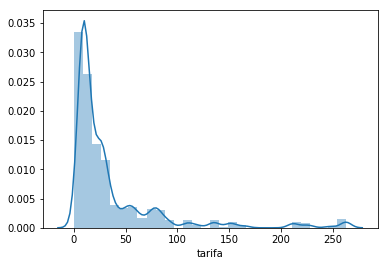

In [6]:
sns.distplot(df['tarifa'], bins=30)
#para el profesor, aquí es interesante hacer una gráfica de la distribución para explorar los datos,
#podemos hacerlo para cualquiera de las variables. Por ejemplo aquí podemos ver que la mayoría 
#de los pasajeros pagaron una tarifa muy baja

También podemos explorar a las variables por pares:

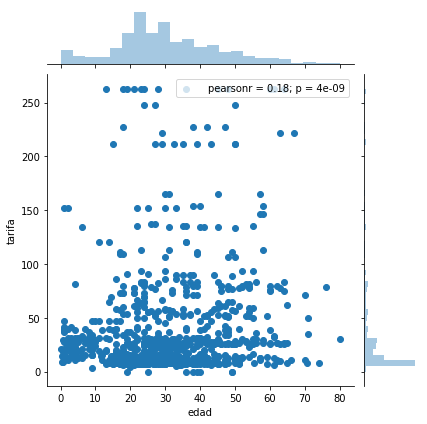

In [7]:
#Para el profesor: para buscar correlaciones entre las variables es necesario graficarlos por pares aquí vemos
# edad contra tarifa: podemos observar que as tarifas mas altas no incluyen a niños pequeños,  mientras que la gente 
# mas pobre parece si llevar a sus niños
sns.jointplot(df['edad'], df['tarifa'])


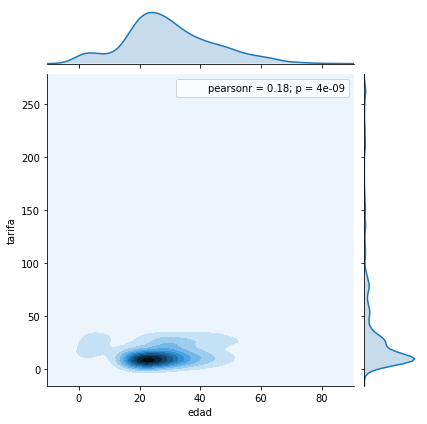

In [8]:
# para el profesor: podemos ver aquí lo sería el centro de gravedad de la gráfica anterior. 
# esto revela que en promedio viajaba gente de 29 años que pagó 35 dólares
sns.jointplot(df['edad'], df['tarifa'], kind= 'kde')


Veamos ahora un panorama general de la información de las variables.

¿Qué observas?

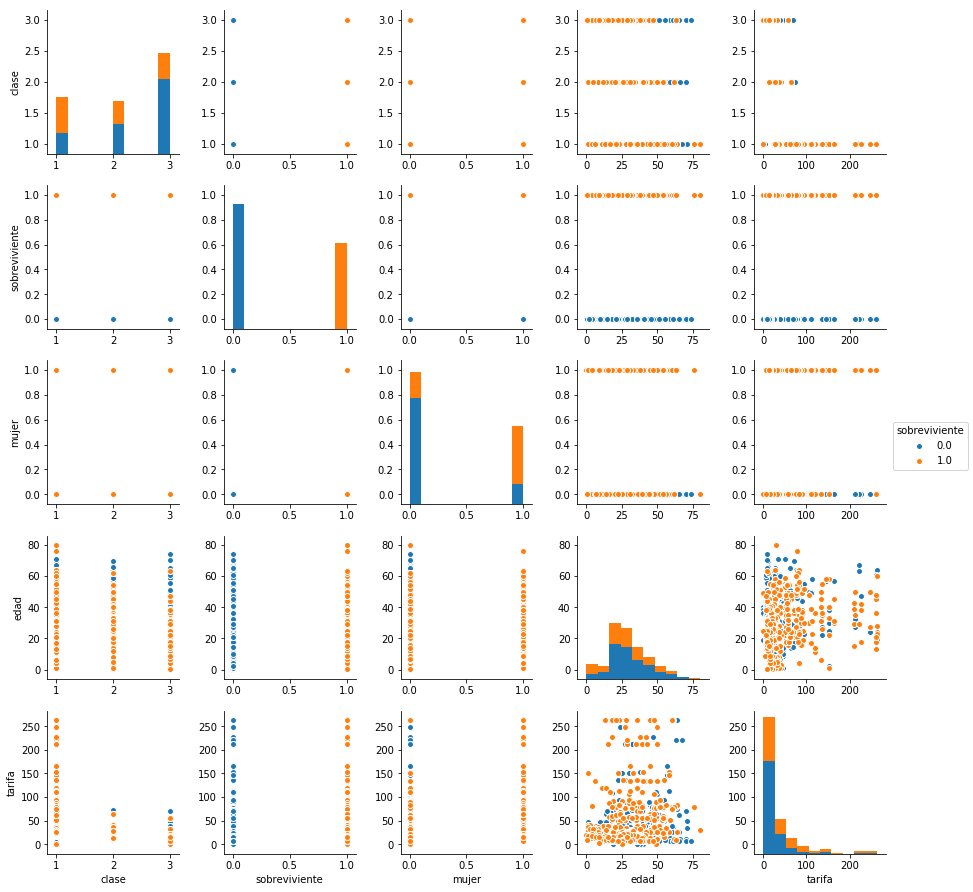

In [9]:

sns.pairplot(df, hue='sobreviviente')


In [10]:
#para el profesor: esta gráfica es muy interesante, en ella se muestran los diagramas de dispersión de todas las variables
# contra toda. Se muestra ademas si la persona sobrevivió (1) o no lo hizo (0)
# podemos por ejemplo observar como había mas hombres que mujeres pero se salvaron proporcinalmente mas mujeres


Ahora aplicaremos el modelo logístico para tratar de predecir si un pasajero sobrevivió o no, basados en la información.

In [11]:
X = df.drop(['sobreviviente'], axis = 1)  # con esto tomamos todas las variables excepto 'sobreviviente' como entradas del modelo
y = df['sobreviviente'] # con esto tomamos solo a la variable 'sobreviviente' como salida esperada 

In [12]:
from sklearn.model_selection import train_test_split  # llamamos a la libreria que divide nuestros datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=50)

In [13]:
from sklearn.linear_model import LogisticRegression
modelo_log = LogisticRegression()  # con esto llamamos al modelo logístico y lo asociamos con la variable modelo_log 

In [14]:
modelo_log.fit(X_train, y_train) # ahora lo corremos en los datos de entrenamiento


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
predicciones_modelo = modelo_log.predict(X_test) # con esto aplicamos el modelo a los datos de prueba 


In [16]:
# para el profesor: aquí podemos ver que la precisión del modelo es de 74%, lo cual nos dice que si bien es cierto 
# que el modelo no es muy preciso si supera ampliamente la barrera del 50%, es decir si nos proporciona información.
# las variables que aparecen son:
# precision es el % de aciertos en la problación de prueba
# recall=exhaustividad es que porcentaje de los sobrevivientes se tuvieron aciertos
# f1-score es la media armónica en los valores anteriores
# support es el tamaño de la muestra de prueba

print(classification_report(y_test, predicciones_modelo))  #ahora vemos un reporte, considera solo la columna 'precision'


             precision    recall  f1-score   support

        0.0       0.75      0.84      0.79       181
        1.0       0.74      0.61      0.67       132

avg / total       0.74      0.74      0.74       313



¿Qué podemos concluir?

In [17]:
#para el profesor: podemos concluir que si es posible en base a los datos predecir 
#solo basados en esta información, el modelo puede mejorarse pero en principio si superó ampliamente a un
#resultado aleatorio

In [38]:
#para el profesor: si quisiéramos probar el modelo con datos seleccionados por nosotros podemos hacerlo:
clase=3
mujer=1
edad=6
tarifa=200
ejemplo = np.array([clase, mujer, edad, tarifa]).reshape(1, -1)

In [39]:
modelo_log.predict(ejemplo) 

array([ 1.])